MSc Project

This aim of this project is to find insights into socio-demographic and economic factors that matter to life satisfaction, the main research question is, What matters most to peoples life satisfaction. The data used in this project is from the UK Data Archive and its a Annual Population Survey Three-Year Pooled Dataset, January 2021 - December 2023.

In [4]:
import pandas as pd

df = pd.read_csv(
    'aps_3yr_jan21dec23_eul_withoutsmoking.tab',
    delimiter='\t',
    low_memory=False,
    dtype={
        'CLAIMS14': 'Int64',  # nullable integer (handles -8 as NA)
        'CombinedAuthorities': 'string'
    },
    na_values=[-8]
)

# View the first few rows
df.head()

,AAGE,ACTHR,ACTHR2,ACTPOT,ACTUOT,ACTWKDY1,ACTWKDY2,ACTWKDY3,ACTWKDY4,ACTWKDY5,...,XDISDDA20,Y2JOB,YLESS20,YMORE,YPAYL20,YPAYM,YPTJOB,YSTART,YTETJB,YVARY99
0,13,-9.0,-9.0,-9.0,-9.0,2.0,3,-9,-9,-9,...,4,-9,-9.0,-9.0,-9.0,-9.0,4.0,-9.0,-9.0,-9.0
1,13,-9.0,-9.0,-9.0,-9.0,-9.0,-9,-9,-9,-9,...,4,-9,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0
2,11,-9.0,-9.0,-9.0,-9.0,-9.0,-9,-9,-9,-9,...,1,-9,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0
3,12,-9.0,-9.0,-9.0,-9.0,-9.0,-9,-9,-9,-9,...,1,-9,-9.0,-9.0,-9.0,-9.0,-9.0,5.0,-9.0,-9.0
4,13,-9.0,-9.0,-9.0,-9.0,-9.0,-9,-9,-9,-9,...,4,-9,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341465 entries, 0 to 341464
Columns: 459 entries, AAGE to YVARY99
dtypes: Int64(1), float64(231), int64(212), object(14), string(1)
memory usage: 1.2+ GB


There are 341465 entries and 459 attributes.

In [7]:
# Count missing values in each column
missing_counts = df.isna().sum()

# Display missing values only for columns that have any
missing_counts[missing_counts > 0]

ACTWKDY1     552
ADDJOB        22
ANXIOUS     1082
APPR12         3
APPRCURR       4
            ... 
YPAYM          9
YPTJOB       253
YSTART         8
YTETJB         1
YVARY99       12
Length: 220, dtype: int64

First to start off the MSc project we need a measurement for the personal wellbeing level of UK citizens.

Pos.348(SATIS)-Overall, how satisfied are you with your life nowadays?

Pos.441(WORTH)-Overall, to what extent do you feel the things you do in your life are worthwhile?

Pos.122(HAPPY)-Overall, how happy did you feel yesterday?

Pos.15(ANXIOUS)-Overall, how anxious did you feel yesterday?

These 4 questions are about personal wellbeings and citizens are asked to respond on a scale of 0 to 10, making it easy for us to analyze. Estimates is then produced by taking the mean ratings of the 4 wellbeing questions. For life satisfaction, life worthwhile and happiness will be combined into one score and anxiety will be done seperatly because they dont mean the same for scores.

In [9]:
# Create Wellbeing column
df['Wellbeing'] = df[['SATIS', 'WORTH', 'HAPPY']].mean(axis=1, skipna=True)

# Check the result
df[['SATIS', 'WORTH', 'HAPPY', 'Wellbeing']].head()

,SATIS,WORTH,HAPPY,Wellbeing
0,8.0,8.0,7.0,7.666667
1,10.0,8.0,10.0,9.333333
2,10.0,9.0,10.0,9.666667
3,-9.0,-9.0,-9.0,-9.000000
4,8.0,5.0,8.0,7.000000


The following code creates labels for hresholds for life satisfaction, worthwhile, happiness and anxiety scores.

In [11]:
# Replace missing codes in ANXIOUS column
df['Wellbeing'] = df['Wellbeing'].replace([-9, -8], pd.NA)
def classify_wellbeing(score):
    if pd.isna(score):
        return pd.NA
    elif score <= 4:
        return 'Low'
    elif score <= 6:
        return 'Medium'
    elif score <= 8:
        return 'High'
    else:
        return 'Very high'

df['Wellbeing_category'] = df['Wellbeing'].apply(classify_wellbeing)

# Replace missing codes in ANXIOUS column
df['ANXIOUS'] = df['ANXIOUS'].replace([-9, -8], pd.NA)

def classify_anxiety(score):
    if pd.isna(score):
        return pd.NA
    elif score <= 1:
        return 'Very low'
    elif score <= 3:
        return 'Low'
    elif score <= 5:
        return 'Medium'
    else:
        return 'High'

df['Anxiety_category'] = df['ANXIOUS'].apply(classify_anxiety)

df[['Wellbeing', 'Wellbeing_category', 'ANXIOUS', 'Anxiety_category']].head()

,Wellbeing,Wellbeing_category,ANXIOUS,Anxiety_category
0,7.666667,High,7.0,High
1,9.333333,Very high,0.0,Very low
2,9.666667,Very high,0.0,Very low
3,<NA>,<NA>,<NA>,<NA>
4,7.0,High,1.0,Very low


In [12]:
df[['Wellbeing', 'Wellbeing_category', 'ANXIOUS', 'Anxiety_category']].isna().sum()

Wellbeing             169132
Wellbeing_category    169132
ANXIOUS               169369
Anxiety_category      169369
dtype: int64

Wellbeing and anxious is our 2 most important measurements, so if data are missing in both of these attributes predictions cannot be made, to prevent bias the entire row is dropped if both Wellbeing and ANXIOUS are missing.

In [14]:
cleaned = df[~(df['Wellbeing'].isna() & df['ANXIOUS'].isna())]

cleaned[['Wellbeing', 'ANXIOUS']].isna().sum()

Wellbeing     11
ANXIOUS      248
dtype: int64

In this reasearch of wellbeing interviewees with age under 16 will be excluded since lots of the determinants are targetted to audiences over 16 and doesnt apply on non adults.

In [16]:
# Remove rows where AAGE indicates "Under 16"
cleaned = cleaned[cleaned['AAGE'] != 1.0]
print(cleaned['AAGE'].value_counts().sort_index())

AAGE
2       293
3       525
4      2909
5      6573
6      9586
7     10685
8     11510
9     11813
10    14584
11    17031
12    18517
13    68318
Name: count, dtype: int64


In [17]:
import pandas as pd
import numpy as np

# Step 1: Define HEALPB2001 to HEALPB2010
health_cols = [f'HEALPB20{str(i).zfill(2)}' for i in range(1, 11)]

# Step 2: Ensure correct dtype
for col in health_cols:
    cleaned[col] = cleaned[col].astype('Int64')

# Step 3: Replace -8 with NaN (keep -9)
cleaned[health_cols] = cleaned[health_cols].replace(-8, np.nan)

# Step 4: Define mapping of health code to descriptive name
health_labels = {
    1: "ArmsOrHands",
    2: "LegsOrFeet",
    3: "BackOrNeck",
    4: "SeeingDifficulty",
    5: "HearingDifficulty",
    6: "SpeechImpediment",
    7: "Disfigurements",
    8: "BreathingProblems",
    9: "HeartOrCirculation",
    10: "DigestiveOrgans",
    11: "Diabetes",
    12: "MentalAnxiety",
    13: "Epilepsy",
    14: "LearningDifficulties",
    15: "MentalIllness",
    16: "ProgressiveIllness",
    17: "OtherProblems",
    18: "Autism"
}

# Step 5: Only create columns if they don’t already exist
for code, label in health_labels.items():
    col_name = f'HEALTH_{label}'
    if col_name not in cleaned.columns:
        cleaned[col_name] = cleaned[health_cols].apply(
            lambda row: int(code in row.dropna().values), axis=1
        )

print("✅ HEALTH columns created safely without duplication.")

✅ HEALTH columns created safely without duplication.


In [46]:
cleaned.to_csv("cleaned.csv", index=False)

In [9]:
import pandas as pd

cleaned = pd.read_csv("cleaned.csv",low_memory=False)

## **Linear regression**


In [11]:
cleaned[['AAGE','SEX','ETHUKEUL','NATIDB11','MARDY6','ILODEFR','TEN1','DISCURR20','HIQUL15D','IN0792SM','RELIGE','GOR9d','HEALTH_Diabetes']].isna().sum()

AAGE                 0
SEX                  0
ETHUKEUL            75
NATIDB11            62
MARDY6               0
ILODEFR              0
TEN1                97
DISCURR20            0
HIQUL15D            15
IN0792SM           142
RELIGE             140
GOR9d                0
HEALTH_Diabetes      0
dtype: int64

In [14]:
from sklearn.model_selection import train_test_split

# Step 1: Define relevant columns
columns = {
    'AGE': 'AAGE',
    'SEX': 'SEX',
    'ETHNICITY': 'ETHUKEUL',
    'MIGRATION': 'NATIDB11',
    'REL_STATUS': 'MARDY6',
    'ECON_ACTIVITY': 'ILODEFR',
    'TENURE': 'TEN1',
    'DISABILITY': 'DISCURR20',
    'QUALIFICATION': 'HIQUL15D',
    'SOCIO_ECON': 'IN0792SM',
    'RELIGION': 'RELIG11',
    'REGION': 'GOR9d',
}

# Step 2: List of relevant columns including target
relevant_cols = list(columns.values()) + ['Wellbeing']

# Step 3: Drop rows with missing values in predictors or target
model_df = cleaned.dropna(subset=relevant_cols).copy()

# Step 4: Define features (X) and target (y)
X = model_df[[v for v in columns.values()]].copy()  
y = model_df['Wellbeing']

# Step 5: Convert all features to categorical type
for col in X.columns:
    X[col] = X[col].astype('category')

# Step 6: One-hot encode all categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# Step 7: First split — 70% train, 30% temporary
X_train, X_temp, y_train, y_temp = train_test_split(
    X_encoded, y, test_size=0.30, random_state=42
)

# Step 8: Second split — 15% validation, 15% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

# Output the shape of each split
print(f"Train: {X_train.shape}")
print(f"Validation: {X_val.shape}")
print(f"Test: {X_test.shape}")


Train: (113859, 73)
Validation: (24399, 73)
Test: (24399, 73)


In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Fit the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Step 2: Predict on validation set
y_val_pred = lr_model.predict(X_val)

# Step 3: Evaluate performance
mse = mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print(f"Validation MSE: {mse:.3f}")
print(f"Validation R²: {r2:.3f}")

Validation MSE: 2.232
Validation R²: 0.131


In [18]:
# Create DataFrame of coefficients
coeff_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_model.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Show top 15 features by absolute influence
coeff_df.head(15).style.format({'Coefficient': '{:.4f}'})

,Feature,Coefficient
54,IN0792SM_16.0,0.9045
39,IN0792SM_1.0,0.6702
6,AAGE_9,-0.6122
44,IN0792SM_6.0,0.6028
28,DISCURR20_1,-0.5848
52,IN0792SM_14.0,0.5814
46,IN0792SM_8.0,0.5811
53,IN0792SM_15.0,0.5780
7,AAGE_10,-0.5777
5,AAGE_8,-0.5770


So these are the top 15 attritubes that affects wellbeing from higher influence to low.

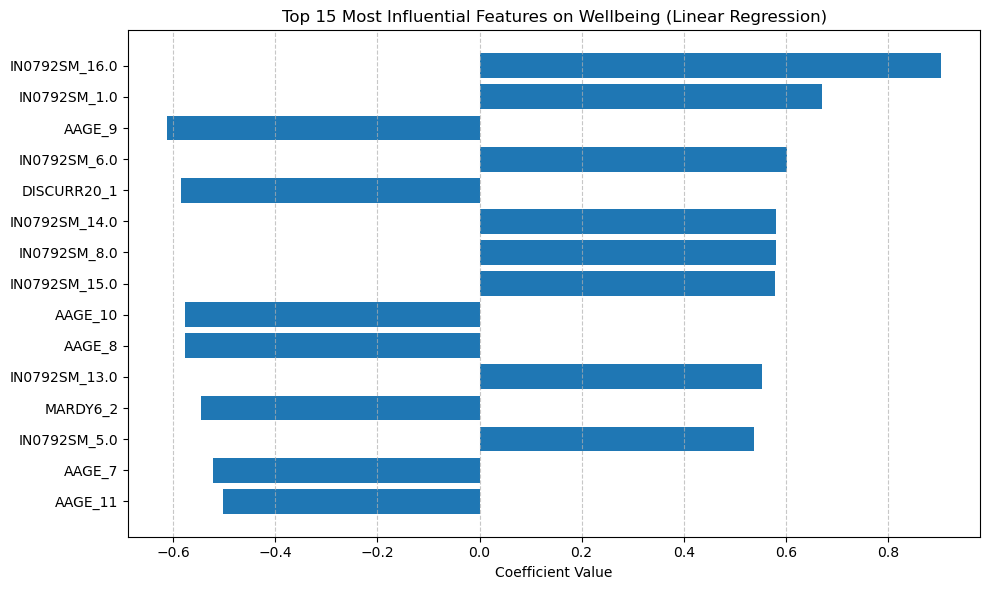

In [20]:
import matplotlib.pyplot as plt


# Bar chart of top 15 eatures by absolute coefficient
top15 = coeff_df.head(15)

plt.figure(figsize=(10, 6))
plt.barh(top15['Feature'][::-1], top15['Coefficient'][::-1])  # reverse for descending order
plt.xlabel('Coefficient Value')
plt.title('Top 15 Most Influential Features on Wellbeing (Linear Regression)')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

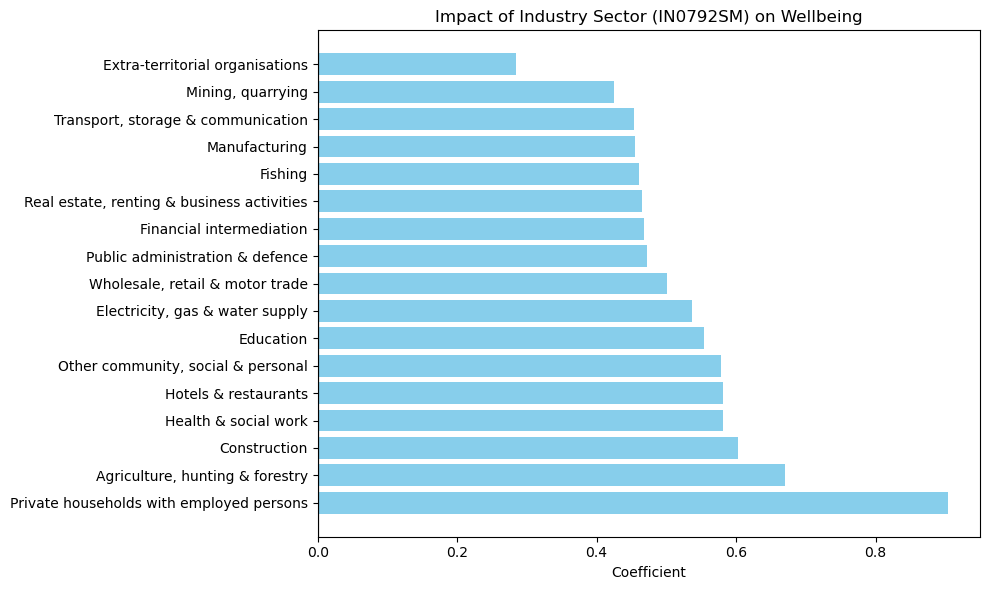

In [22]:
# Step 1: Define human-readable labels for IN0792SM (industry)
industry_labels = {
    -9.0: "Does not apply",
    -8.0: "No answer",
     1.0: "Agriculture, hunting & forestry",
     2.0: "Fishing",
     3.0: "Mining, quarrying",
     4.0: "Manufacturing",
     5.0: "Electricity, gas & water supply",
     6.0: "Construction",
     7.0: "Wholesale, retail & motor trade",
     8.0: "Hotels & restaurants",
     9.0: "Transport, storage & communication",
    10.0: "Financial intermediation",
    11.0: "Real estate, renting & business activities",
    12.0: "Public administration & defence",
    13.0: "Education",
    14.0: "Health & social work",
    15.0: "Other community, social & personal",
    16.0: "Private households with employed persons",
    17.0: "Extra-territorial organisations"
}

# Step 2: Create coefficient DataFrame from model
coeff_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_model.coef_
})

# Step 3: Filter only IN0792SM features and map labels
industry_coeffs = coeff_df[coeff_df['Feature'].str.startswith('IN0792SM_')].copy()
industry_coeffs['Code'] = industry_coeffs['Feature'].str.extract(r'IN0792SM_(.*)').astype(float)
industry_coeffs['Label'] = industry_coeffs['Code'].map(industry_labels)

# Step 4: Sort by absolute coefficient value
industry_coeffs = industry_coeffs.sort_values(by='Coefficient', ascending=False)

# Step 5: Plot
plt.figure(figsize=(10, 6))
plt.barh(industry_coeffs['Label'], industry_coeffs['Coefficient'], color='skyblue')
plt.xlabel('Coefficient')
plt.title('Impact of Industry Sector (IN0792SM) on Wellbeing')
plt.axvline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()

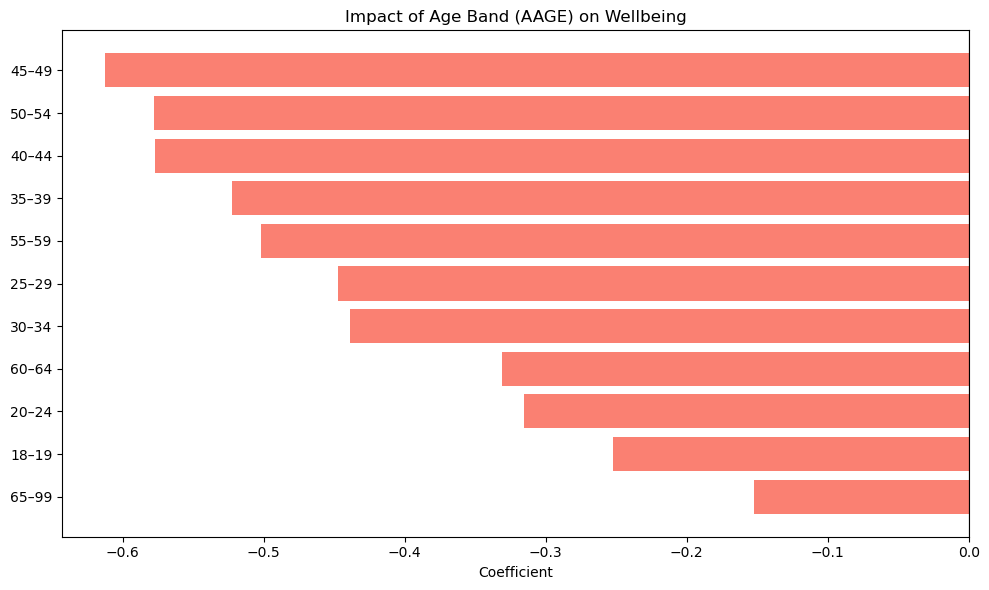

In [24]:
# Step 1: Define human-readable labels for AAGE
aage_labels = {
    -9.0: "Does not apply",
    -8.0: "No answer",
     1.0: "Under 16",
     2.0: "16–17",
     3.0: "18–19",
     4.0: "20–24",
     5.0: "25–29",
     6.0: "30–34",
     7.0: "35–39",
     8.0: "40–44",
     9.0: "45–49",
    10.0: "50–54",
    11.0: "55–59",
    12.0: "60–64",
    13.0: "65–99"
}

# Step 2: Create coefficient DataFrame
coeff_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_model.coef_
})

# Step 3: Filter features starting with 'AAGE_' (after one-hot encoding)
aage_coeffs = coeff_df[coeff_df['Feature'].str.startswith('AAGE_')].copy()
aage_coeffs['Code'] = aage_coeffs['Feature'].str.extract(r'AAGE_(.*)').astype(float)
aage_coeffs['Label'] = aage_coeffs['Code'].map(aage_labels)

# Step 4: Sort by coefficient
aage_coeffs = aage_coeffs.sort_values(by='Coefficient', ascending=False)

# Step 5: Plot
plt.figure(figsize=(10, 6))
plt.barh(aage_coeffs['Label'], aage_coeffs['Coefficient'], color='salmon')
plt.xlabel('Coefficient')
plt.title('Impact of Age Band (AAGE) on Wellbeing')
plt.axvline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()

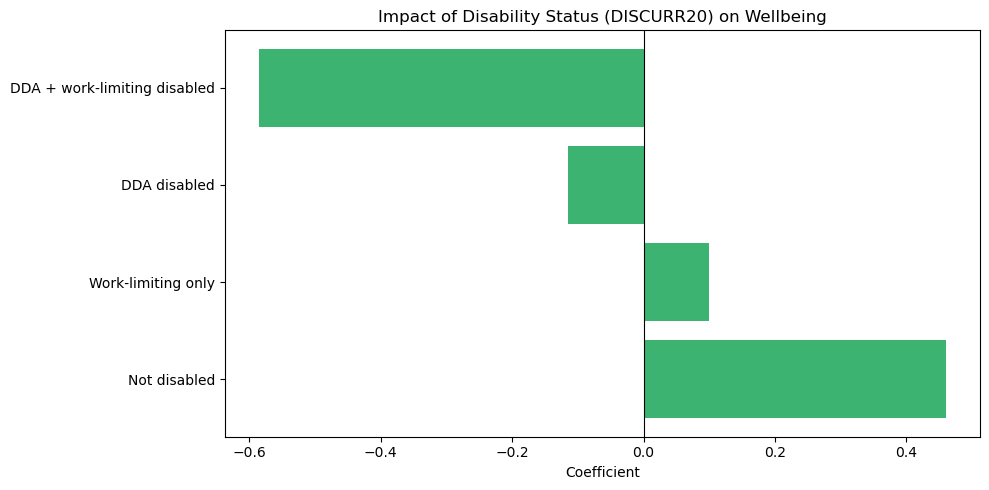

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Define human-readable labels for DISCURR20
discurr_labels = {
    -9.0: "Does not apply",
    -8.0: "No answer",
     1.0: "DDA + work-limiting disabled",
     2.0: "DDA disabled",
     3.0: "Work-limiting only",
     4.0: "Not disabled"
}

# Step 2: Create DataFrame of coefficients
coeff_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_model.coef_
})

# Step 3: Filter features related to DISCURR20
discurr_coeffs = coeff_df[coeff_df['Feature'].str.startswith('DISCURR20_')].copy()
discurr_coeffs['Code'] = discurr_coeffs['Feature'].str.extract(r'DISCURR20_(.*)').astype(float)
discurr_coeffs['Label'] = discurr_coeffs['Code'].map(discurr_labels)

# Step 4: Sort and visualize
discurr_coeffs = discurr_coeffs.sort_values(by='Coefficient', ascending=False)

# Step 5: Plot
plt.figure(figsize=(10, 5))
plt.barh(discurr_coeffs['Label'], discurr_coeffs['Coefficient'], color='mediumseagreen')
plt.xlabel('Coefficient')
plt.title('Impact of Disability Status (DISCURR20) on Wellbeing')
plt.axvline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()

In conclusion for linear regression, the model isn't capturing the relationship between the predictors and wellbeing effectively because Wellbeing is influenced by complex, nonlinear, and interacting factors like health and income. Linear models assume a straight-line relationship, which rarely holds in social science.

In [30]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Assuming `cleaned` and `columns` dict are already defined
results = []

# Loop through each attribute defined in `columns`
for name, col in columns.items():
    df_subset = cleaned[[col, 'Wellbeing']].dropna()
    
    # Skip if not enough data
    if df_subset[col].nunique() < 2:
        continue

    X = df_subset[[col]]
    y = df_subset['Wellbeing']
    
    # One-hot encode the single column
    X_encoded = pd.get_dummies(X, drop_first=True)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_encoded, y, test_size=0.3, random_state=42
    )

    # Train Random Forest
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    results.append((name, col, r2, mse))

# Results DataFrame
results_df = pd.DataFrame(results, columns=["Attribute", "Column", "R² Score", "MSE"])
results_df = results_df.sort_values("R² Score", ascending=False)

# Display results
print(results_df)

        Attribute     Column  R² Score       MSE
7      DISABILITY  DISCURR20  0.081011  2.358968
4      REL_STATUS     MARDY6  0.045103  2.451140
6          TENURE       TEN1  0.029179  2.513600
0             AGE       AAGE  0.008480  2.545147
10       RELIGION    RELIG11  0.007842  2.588792
5   ECON_ACTIVITY    ILODEFR  0.005192  2.553586
9      SOCIO_ECON   IN0792SM  0.002174  2.544997
8   QUALIFICATION   HIQUL15D  0.000618  2.567793
11         REGION      GOR9d  0.000566  2.565462
2       ETHNICITY   ETHUKEUL  0.000524  2.574292
3       MIGRATION   NATIDB11  0.000085  2.566235
1             SEX        SEX  0.000002  2.566910


🌲 Random Forest Validation MSE: 2.530
🌲 Random Forest Validation R²: 0.015


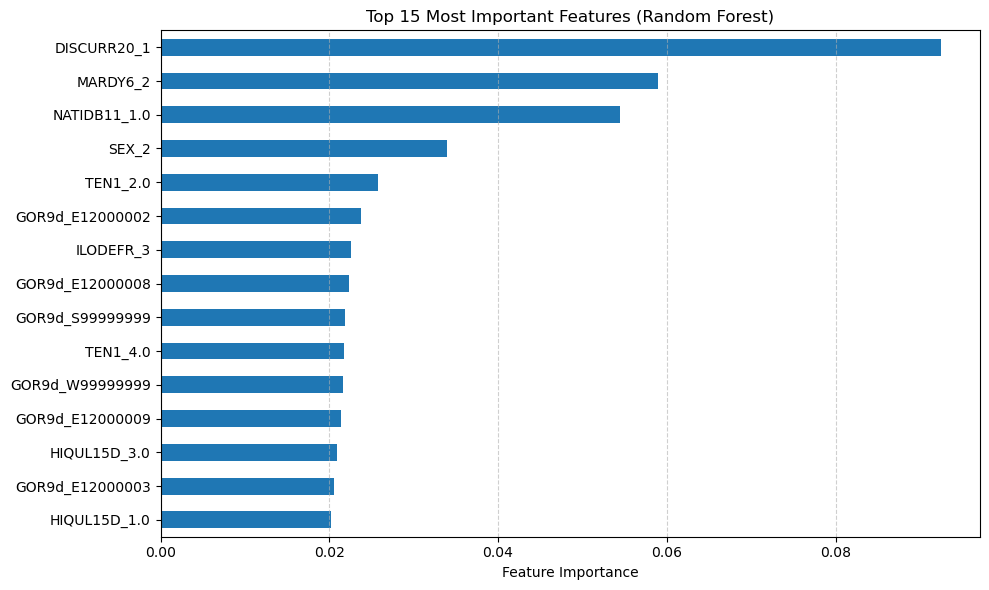

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Step 2: Predict on validation set
y_val_pred_rf = rf_model.predict(X_val)

# Step 3: Evaluate performance
mse_rf = mean_squared_error(y_val, y_val_pred_rf)
r2_rf = r2_score(y_val, y_val_pred_rf)

print(f"🌲 Random Forest Validation MSE: {mse_rf:.3f}")
print(f"🌲 Random Forest Validation R²: {r2_rf:.3f}")

# Step 4: Feature importance plot
importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
top15_rf = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 6))
top15_rf[::-1].plot(kind='barh')  # reverse for descending order
plt.title("Top 15 Most Important Features (Random Forest)")
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()